In [1]:
# Pillow is installed but import PIL due to backward dependency
from PIL import Image
from tesserocr import PyTessBaseAPI, RIL

In [2]:
base = '/Users/macbook/Desktop/images/'
index = 1
path = base + str(index) + '.png'
image = Image.open(path)

In [3]:
api = PyTessBaseAPI()
api.SetImage(image)
boxes = api.GetComponentImages(RIL.TEXTLINE, True)
print '-----------------------'
print 'Found {} text labels.'.format(len(boxes))
print '-----------------------'
# im is a PIL image object
# box is a dict with keys x, y, w and h
for i, (im, box, _, _) in enumerate(boxes):
    api.SetRectangle(box['x'], box['y'], box['w'], box['h'])
    ocrResult = api.GetUTF8Text()
    conf = api.MeanTextConf()
    if conf < 70: continue
    print (u"[{0}]: x={x:3}, y={y:3}, w={w:3}, h={h:3}, "
           "confidence: {1:2}, text: {2}").format(i, conf, ocrResult, **box)

-----------------------
Found 9 text labels.
-----------------------
[2]: x=371, y=160, w=199, h= 18, confidence: 83, text: Test tube holder


[3]: x=417, y=206, w=144, h= 24, confidence: 84, text: Boiling tube


[4]: x=417, y=252, w=144, h= 18, confidence: 77, text: Lead nitrate


[5]: x=416, y=381, w= 86, h= 18, confidence: 84, text: Burner


[6]: x= 44, y=589, w=160, h= 28, confidence: 89, text: Figure 1 .5


[7]: x= 45, y=624, w=387, h= 29, confidence: 84, text: Heating of lead nitrate and


[8]: x= 46, y=660, w=381, h= 29, confidence: 84, text: emission of nitrogen dioxide




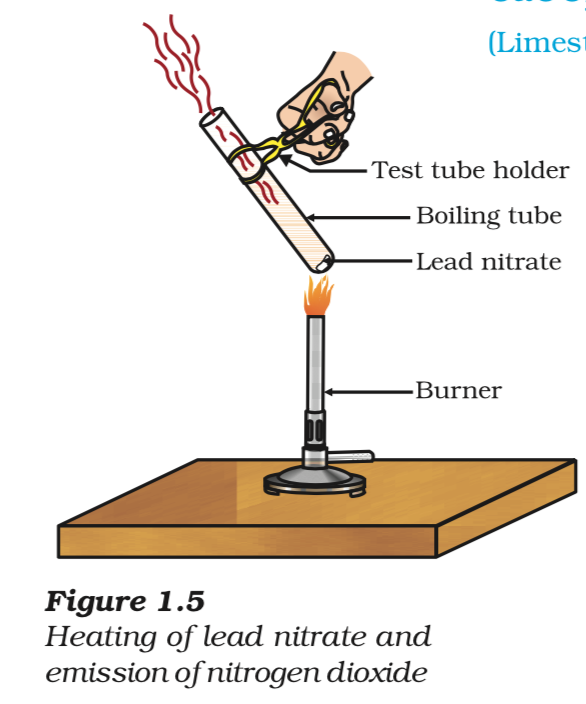

In [4]:
from IPython.display import Image
Image(path) 